In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/RUL/5. 배터리 RUL 예측/Battery_RUL_data.csv')

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.columns

In [ ]:
df[:20]

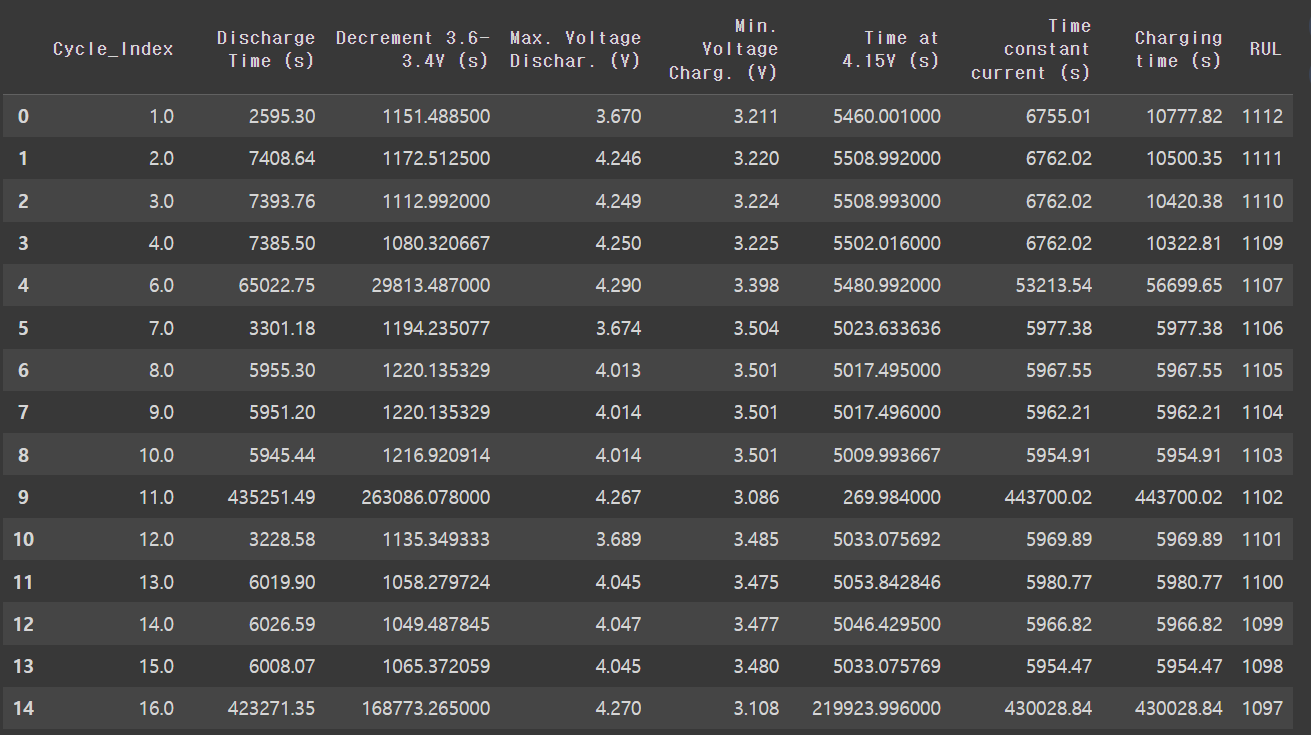

In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots

# Selecting only float64 data columns
float_cols = df.select_dtypes(include=['float64']).columns

# Splitting columns into groups of 3
col_sets = [float_cols[n:n+3] for n in range(0, len(float_cols), 3)]

for cols in col_sets:
    # Change rows and cols to make it horizontal
    fig = make_subplots(rows=len(cols), cols=1, subplot_titles=cols)
    for idx, col in enumerate(cols, start=1):
        hist_fig = px.histogram(df, x=col)
        for trace in hist_fig.data:
            fig.add_trace(trace, row=idx, col=1)  # Change the row and col
    fig.show()


In [ ]:
import plotly.express as px

# Selecting only float64 data columns
float_cols = df.select_dtypes(include=['float64']).columns

for col in float_cols:
    fig = px.histogram(df, x=col, histnorm='percent', cumulative=True)
    fig.update_layout(title=f'Cumulative Distribution Function for {col}')
    fig.show()


## 이상치
### Z-score:
- 정규분포 가정: Z-score는 데이터가 근사적으로 정규분포를 따르는 경우 더 효과적입니다. Z-score는 데이터 포인트의 값이 평균에서 얼마나 떨어져 있는지를 나타내며, 표준편차 단위로 측정됩니다. <br>
- 표준화된 척도: Z-score는 데이터의 절대적인 값을 사용하지 않기 때문에 다양한 데이터 집합 간에 이상치를 비교하거나 식별하는 데 유용합니다.<br>
- 정확한 위치 식별: Z-score는 각 데이터 포인트에 대해 개별적으로 계산되므로 이상치의 정확한 위치를 식별하는 데 도움이 됩니다.<br>

### IQR:
- 비정규분포 데이터: IQR은 데이터가 정규분포를 따르지 않을 때 또는 분포에 대해 알 수 없을 때 유용합니다.<br>
- 로버스트성: IQR은 중앙값과 사분위수를 기반으로 하므로, 극단값에 덜 민감하며, 이상치의 영향을 적게 받습니다.

In [ ]:
specified_cols = ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)']


In [ ]:
from scipy import stats
# Shapiro-Wilk test
normality_results = {}

for col in specified_cols:
    stat, p = stats.shapiro(df[col])
    normality_results[col] = p > 0.05

normality_results


In [ ]:
import scipy
from scipy.stats import zscore

In [ ]:
#평균과 표준편차를 사용하여 z-score를 계산하고, z-score가 일정 임계값을 초과하는 값을 이상치로 간주

def zscore_outliers(data, column, threshold=3):
    z_scores = np.abs(zscore(data[column]))
    return np.where(z_scores > threshold)[0]
zscore_outliers_dict = {}
for col in specified_cols:
    zscore_outliers_dict[col] = zscore_outliers(df, col)

combined_outliers_z = set()
for col in specified_cols:
    combined_outliers_z.update(zscore_outliers_dict[col])

df_cleaned_z = df.drop(index=combined_outliers_z).reset_index(drop=True)

df_cleaned_z


In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots

float_cols = df_cleaned_z.select_dtypes(include=['float64']).columns

col_sets = [float_cols[n:n+3] for n in range(0, len(float_cols), 3)]

for cols in col_sets:
    fig = make_subplots(rows=len(cols), cols=1, subplot_titles=cols)
    for idx, col in enumerate(cols, start=1):
        hist_fig = px.histogram(df_cleaned_z, x=col)
        for trace in hist_fig.data:
            fig.add_trace(trace, row=idx, col=1)
    fig.show()


In [ ]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR


    filtered = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    return filtered

for col in specified_cols:
    df_IQR = remove_outliers_iqr(df, col)

df_IQR.reset_index(drop=True, inplace=True)
df_IQR


In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots

float_cols = df_IQR.select_dtypes(include=['float64']).columns

col_sets = [float_cols[n:n+3] for n in range(0, len(float_cols), 3)]

for cols in col_sets:
    fig = make_subplots(rows=len(cols), cols=1, subplot_titles=cols)
    for idx, col in enumerate(cols, start=1):
        hist_fig = px.histogram(df_IQR, x=col)
        for trace in hist_fig.data:
            fig.add_trace(trace, row=idx, col=1)
    fig.show()


## 변수 관계 분석

In [ ]:
df_IQR.head(10)

In [ ]:
import plotly.figure_factory as ff

correlation_matrix = df_IQR.corr()

correlation_matrix = correlation_matrix.round(2)

x_labels = correlation_matrix.columns.tolist()
y_labels = correlation_matrix.index.tolist()

fig = ff.create_annotated_heatmap(z=correlation_matrix.values,
                                  x=x_labels,
                                  y=y_labels,
                                  colorscale='Viridis',
                                  showscale=True)
fig.show()


## 전처리

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
X = df_IQR.drop(['RUL','Cycle_Index'], axis=1)
y = df_IQR['RUL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)  #train꺼로 transform한걸로 fit 중요!!!!
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## shap

In [ ]:
pip install shap plotly

In [ ]:
pip install optuna

In [ ]:
import optuna
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best Hyperparameters:", best_params)

In [ ]:
best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

best_model.fit(X_train_scaled, y_train)

explainer = shap.Explainer(best_model, X_train_scaled)

shap_values = explainer.shap_values(X_test_scaled)

In [ ]:
#  SHAP summary plot
summary_plot = shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

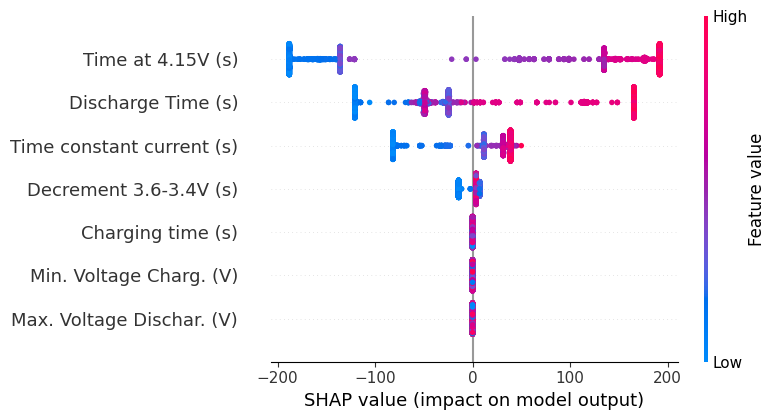

In [ ]:
import shap
import matplotlib.pyplot as plt

best_model.fit(X_train_scaled, y_train)

explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)


# 중요도 순으로
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]
sorted_features = [X.columns[i] for i in sorted_indices]
sorted_shap_values = mean_abs_shap_values[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_shap_values, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Variable Importance Based on Mean Absolute SHAP Values')
plt.gca().invert_yaxis()
plt.show()


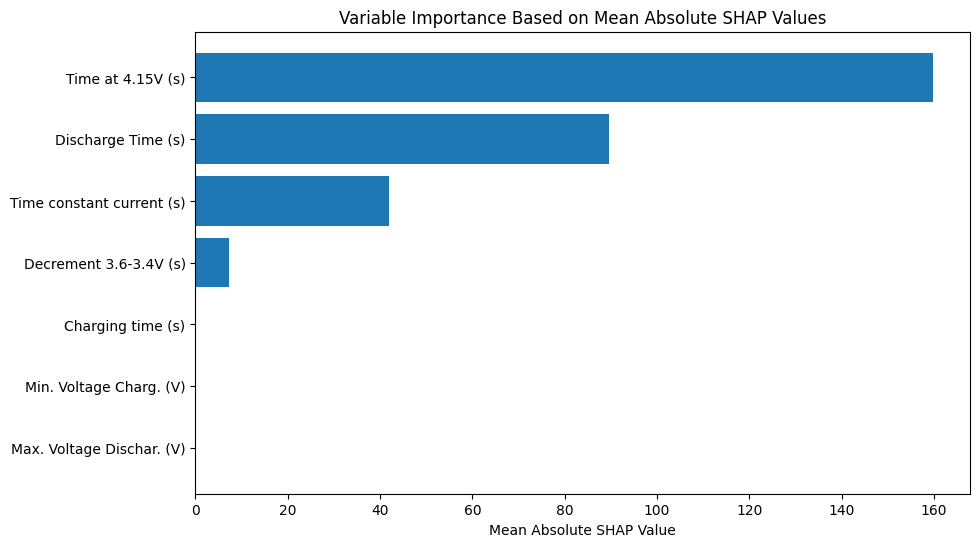

## EMD-CNN-LSTM 모델

[EMD-CNN-LSTM](http://210.101.116.16/xml/html/%EC%A0%84%EB%A0%A5%EC%A0%84%EC%9E%90%ED%95%99%ED%9A%8C/%EA%B5%AD%EB%AC%B8/27_1/7.%EC%9E%84%EC%A0%9C%EC%98%81/%EC%9E%84%EC%A0%9C%EC%98%81.html)

[EMD](https://neosla.tistory.com/34)

EMD: 시계열 데이터를 IMF로 분해합니다. <br>
CNN: 각 IMF를 CNN을 통해 처리하고 특징을 추출합니다.<br>
LSTM: CNN에서 추출된 특징을 LSTM에 공급하여 시계열 예측을 수행합니다.

In [ ]:
pip install EMD-signal

In [ ]:
from PyEMD import EMD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
import numpy as np

# 데이터 준비 및 EMD 분해
selected_column = X_train_scaled[:, 0]
emd = EMD()
IMFs = emd(selected_column)

# IMFs의 형태 재구성
IMFs_reshaped = IMFs.T.reshape(IMFs.shape[1], IMFs.shape[0], 1)

# EMD-CNN-LSTM 모델 구성
EMD_CNN_LSTM_model = Sequential([
    # 첫 번째 CNN 레이어
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(IMFs_reshaped.shape[1], IMFs_reshaped.shape[2])),
    MaxPooling1D(pool_size=2),
    # 두 번째 CNN 레이어
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    # 첫 번째 LSTM 레이어
    LSTM(50, return_sequences=True),  # 다음 LSTM 레이어에 연결하기 위해 return_sequences=True 설정
    # 두 번째 LSTM 레이어
    LSTM(50),
    Dense(50, activation='relu'),
    Dense(1)
])

EMD_CNN_LSTM_model.compile(optimizer='adam', loss='mse')

train_size = int(len(IMFs_reshaped) * 0.8)
train_IMFs, test_IMFs = IMFs_reshaped[:train_size], IMFs_reshaped[train_size:]
train_y, test_y = y_train[:train_size], y_train[train_size:]

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('EMD_CNN_LSTM_best_model.h5', monitor='val_loss', save_best_only=True)

history = EMD_CNN_LSTM_model.fit(train_IMFs, train_y, epochs=100, batch_size=16, validation_data=(test_IMFs, test_y),
                    callbacks=[early_stopping, model_checkpoint])


In [ ]:
import plotly.graph_objects as go
import numpy as np

# 학습 및 검증 손실 그리기
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['loss']) + 1),
                         y=history.history['loss'],
                         mode='lines',
                         name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['val_loss']) + 1),
                         y=history.history['val_loss'],
                         mode='lines',
                         name='Validation Loss'))

fig.update_layout(title='Training and Validation Loss Over Epochs',
                  xaxis_title='Epochs',
                  yaxis_title='Loss',
                  legend=dict(x=0, y=1),
                  template='plotly_dark')

fig.show()


In [ ]:
# 예측 결과 그리기
y_pred = EMD_CNN_LSTM_model.predict(test_IMFs)

fig = go.Figure()

fig.add_trace(go.Scatter(y=test_y, mode='lines', name='Actual RUL'))
fig.add_trace(go.Scatter(y=y_pred.flatten(), mode='lines', name='Predicted RUL (EMD-CNN-LSTM)'))

fig.update_layout(title='Actual vs Predicted RUL (EMD-CNN-LSTM)', xaxis_title='Index', yaxis_title='RUL Value')

fig.show()

In [ ]:
# Calculating the Mean Absolute Percentage Error (MAPE)
mape = 100 * np.mean(np.abs((test_y - y_pred.flatten()) / test_y))
mape

In [ ]:
# 37.18067879747117

# EMD-CNN 모델![newplot (74).png](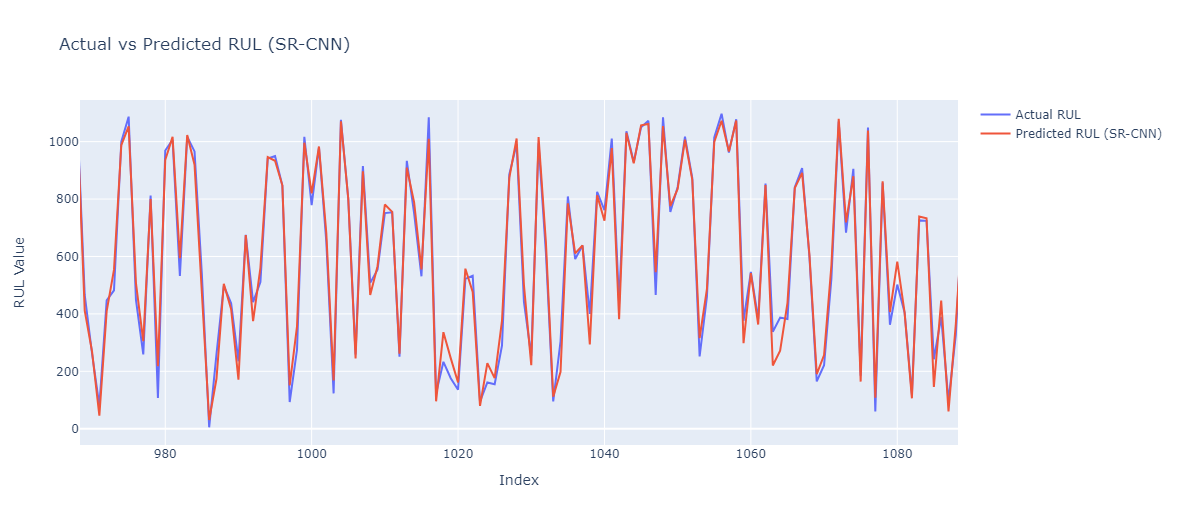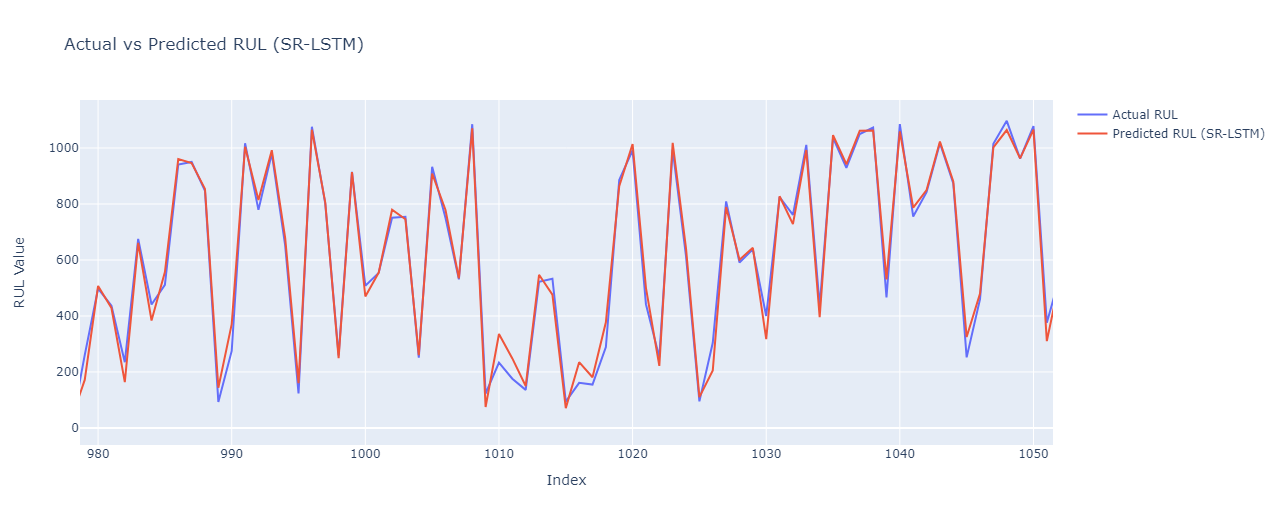)

In [ ]:
from PyEMD import EMD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EMD 분해
selected_column = X_train_scaled[:, 0]
emd = EMD()
IMFs = emd(selected_column)

# IMFs 재구조화
IMFs_reshaped = IMFs.T.reshape(IMFs.shape[1], IMFs.shape[0], 1)

# EMD-CNN 모델 생성
EMD_CNN_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(IMFs_reshaped.shape[1], IMFs_reshaped.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

EMD_CNN_model.compile(optimizer='adam', loss='mse')

train_size = int(len(IMFs_reshaped) * 0.8)
train_IMFs, test_IMFs = IMFs_reshaped[:train_size], IMFs_reshaped[train_size:]
train_y, test_y = y_train[:train_size], y_train[train_size:]

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('EMD_CNN_best_model.h5', monitor='val_loss', save_best_only=True)

history = EMD_CNN_model.fit(train_IMFs, train_y, epochs=100, batch_size=16, validation_data=(test_IMFs, test_y),
                    callbacks=[early_stopping, model_checkpoint])


In [ ]:
import plotly.graph_objects as go
import numpy as np


fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['loss']) + 1),
                         y=history.history['loss'],
                         mode='lines',
                         name='Train Loss'))

fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['val_loss']) + 1),
                         y=history.history['val_loss'],
                         mode='lines',
                         name='Validation Loss'))

fig.update_layout(title='Training and Validation Loss Over Epochs',
                  xaxis_title='Epochs',
                  yaxis_title='Loss',
                  legend=dict(x=0, y=1),
                  template='plotly_dark')

fig.show()


In [ ]:
y_pred = EMD_CNN_model.predict(test_IMFs)

fig = go.Figure()

fig.add_trace(go.Scatter(y=test_y, mode='lines', name='Actual RUL'))
fig.add_trace(go.Scatter(y=y_pred.flatten(), mode='lines', name='Predicted RUL (EMD-CNN)'))
fig.update_layout(title='Actual vs Predicted RUL (EMD-CNN)', xaxis_title='Index', yaxis_title='RUL Value')
fig.show()


In [ ]:
import numpy as np

mape = 100 * np.mean(np.abs((test_y - y_pred.flatten()) / test_y))

print(f'MAPE: {mape}')


In [ ]:
# 35.34106901115083

In [ ]:
SR_signal.shape

In [ ]:
SR_signal_reshaped.shape

## SR-CNN 모델

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from scipy.fft import fft, ifft

def spectral_residual_transform(signal):
    """Spectral Residual 변환을 수행하는 함수"""
    fft_result = fft(signal)
    log_amplitude = np.log(np.abs(fft_result) + 1e-8)
    average_spectrum = np.mean(log_amplitude)
    spectral_residual = log_amplitude - average_spectrum
    spectral_residual_signal = np.abs(ifft(np.exp(spectral_residual + 1j * np.angle(fft_result))))
    return spectral_residual_signal

# 선택된 데이터 열에 SR 변환 적용
selected_column = X_train_scaled[:, 0]
SR_signal = spectral_residual_transform(selected_column)

time_steps = 10
samples = len(SR_signal) - time_steps + 1
SR_signal_reshaped = np.zeros((samples, time_steps, 1))  # 마지막 차원 1은 특징 수를 의미

for i in range(samples):
    SR_signal_reshaped[i] = SR_signal[i:i+time_steps].reshape(-1, 1)

# SR-CNN 모델 구성
SR_CNN_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SR_signal_reshaped.shape[1], SR_signal_reshaped.shape[2])),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

SR_CNN_model.compile(optimizer='adam', loss='mse')

# 훈련 및 테스트 데이터 분할
train_size = int(len(SR_signal_reshaped) * 0.8)
train_SR_signal, test_SR_signal = SR_signal_reshaped[:train_size], SR_signal_reshaped[train_size:]

# y_train 재구성하기
y_train_reshaped = y_train[:samples]

# 이후 훈련 및 테스트 데이터 분할
train_y, test_y = y_train_reshaped[:train_size], y_train_reshaped[train_size:]

# 콜백 함수 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_SR_CNN_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# 모델 훈련
history = SR_CNN_model.fit(train_SR_signal, train_y, epochs=100, batch_size=16, validation_data=(test_SR_signal, test_y),
                    verbose=2, callbacks=[early_stopping, model_checkpoint])


In [ ]:
import numpy as np
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['loss']) + 1),
                         y=history.history['loss'],
                         mode='lines',
                         name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['val_loss']) + 1),
                         y=history.history['val_loss'],
                         mode='lines',
                         name='Validation Loss'))

fig.update_layout(title='Training and Validation Loss Over Epochs',
                  xaxis_title='Epochs',
                  yaxis_title='Loss',
                  legend=dict(x=0, y=1),
                  template='plotly_dark')

fig.show()


In [ ]:
# SR-CNN 모델을 통한 예측
y_pred_SR_CNN = SR_CNN_model.predict(test_SR_signal)

fig = go.Figure()

fig.add_trace(go.Scatter(y=test_y, mode='lines', name='Actual RUL'))

# SR-CNN 모델을 통한 RUL 예측값
fig.add_trace(go.Scatter(y=y_pred_SR_CNN.flatten(), mode='lines', name='Predicted RUL (SR-CNN)'))

fig.update_layout(title='Actual vs Predicted RUL (SR-CNN)',
                  xaxis_title='Index',
                  yaxis_title='RUL Value')

fig.show()


In [ ]:
# Mean Absolute Percentage Error (MAPE) 계산
mape = 100 * np.mean(np.abs((test_y - y_pred_SR_CNN.flatten()) / test_y))
print(f"{mape}")

In [ ]:
# 36.98722305392734

# EMD-LSTM 모델

In [ ]:
from PyEMD import EMD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# 선택된 데이터 열에서 IMFs 추출
selected_column = X_train_scaled[:, 0]
emd = EMD()
IMFs = emd(selected_column)

# LSTM 모델에 입력하기 위한 데이터 형태 변환
IMFs_reshaped = IMFs.T.reshape(IMFs.shape[1], IMFs.shape[0], 1)

# EMD-LSTM 모델 구성
EMD_LSTM_model = Sequential()
EMD_LSTM_model.add(LSTM(50, input_shape=(IMFs_reshaped.shape[1], IMFs_reshaped.shape[2]), return_sequences=True))
EMD_LSTM_model.add(LSTM(50))
EMD_LSTM_model.add(Dense(1))
EMD_LSTM_model.compile(optimizer='adam', loss='mse')

# 훈련 및 테스트 데이터 분할
train_size = int(len(IMFs_reshaped) * 0.8)
train_IMFs, test_IMFs = IMFs_reshaped[:train_size], IMFs_reshaped[train_size:]
train_y, test_y = y_train[:train_size], y_train[train_size:]

# 콜백 함수 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# 모델 훈련
history = EMD_LSTM_model.fit(train_IMFs, train_y, epochs=100, batch_size=16, validation_data=(test_IMFs, test_y),
                    verbose=2, callbacks=[early_stopping, model_checkpoint])


In [ ]:
import numpy as np
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['loss']) + 1),
                         y=history.history['loss'],
                         mode='lines',
                         name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['val_loss']) + 1),
                         y=history.history['val_loss'],
                         mode='lines',
                         name='Validation Loss'))

fig.update_layout(title='Training and Validation Loss Over Epochs',
                  xaxis_title='Epochs',
                  yaxis_title='Loss',
                  legend=dict(x=0, y=1),
                  template='plotly_dark')

fig.show()



In [ ]:
# EMD-LSTM 모델을 통한 예측
y_pred_EMD_LSTM = EMD_LSTM_model.predict(test_IMFs)

fig = go.Figure()

fig.add_trace(go.Scatter(y=test_y, mode='lines', name='Actual RUL'))

# 예측된 RUL (EMD-LSTM)
fig.add_trace(go.Scatter(y=y_pred_EMD_LSTM.flatten(), mode='lines', name='Predicted RUL (EMD-LSTM)'))

fig.update_layout(title='Actual vs Predicted RUL (EMD-LSTM)',
                  xaxis_title='Index',
                  yaxis_title='RUL Value')

fig.show()

In [ ]:
mape = 100 * np.mean(np.abs((test_y - y_pred_EMD_LSTM.flatten()) / test_y))
mape

In [ ]:
# 30.377389011594975

### window size 설정 경우

In [ ]:
from PyEMD import EMD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import numpy as np

selected_column = X_train_scaled[:, 0]
emd = EMD()
IMFs = emd(selected_column)

IMFs_reshaped = IMFs.T.reshape(IMFs.shape[1], IMFs.shape[0], 1)

# 윈도우 데이터 준비
WINDOW_SIZE = 72
dataset_train = tf.data.Dataset.from_tensor_slices(IMFs_reshaped)
windowed_dataset = dataset_train.window(WINDOW_SIZE, shift=1, drop_remainder=True)
windowed_dataset = windowed_dataset.flat_map(lambda window: window.batch(WINDOW_SIZE))
windowed_dataset = windowed_dataset.map(lambda window: (window[:-1], window[-1:]))
windowed_dataset = windowed_dataset.batch(1)

# EMD-LSTM 모델 구성
Win_EMD_LSTM_model = Sequential([
    LSTM(50, input_shape=(WINDOW_SIZE - 1, IMFs.shape[0]), return_sequences=True),
    LSTM(50),
    Dense(1)
])
Win_EMD_LSTM_model.compile(optimizer='adam', loss='mse')


early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

train_dataset = windowed_dataset.take(int(len(IMFs_reshaped) * 0.8))
test_dataset = windowed_dataset.skip(int(len(IMFs_reshaped) * 0.8))

history = Win_EMD_LSTM_model.fit(train_dataset, epochs=100, validation_data=test_dataset,
                                 verbose=2, callbacks=[early_stopping, model_checkpoint])

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['loss']) + 1),
                         y=history.history['loss'],
                         mode='lines',
                         name='Train Loss'))

fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['val_loss']) + 1),
                         y=history.history['val_loss'],
                         mode='lines',
                         name='Validation Loss'))

fig.update_layout(title='Training and Validation Loss Over Epochs',
                  xaxis_title='Epochs',
                  yaxis_title='Loss',
                  legend=dict(x=0, y=1),
                  template='plotly_dark')

fig.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(y=y_test_trimmed, mode='lines', name='Actual RUL'))

fig.add_trace(go.Scatter(y=y_pred_trimmed.flatten(), mode='lines', name='Predicted RUL'))

fig.update_layout(title='Actual vs Predicted RUL', xaxis_title='Index', yaxis_title='RUL Value')
fig.show()

In [ ]:
y_test_trimmed = y_test[sequence_length:]
y_pred_trimmed = y_pred_baseline_single_step[sequence_length:]

In [ ]:
mape = mean_absolute_percentage_error(y_test_trimmed, y_pred_trimmed)
mape

In [ ]:
# 99.63772567056276

## SR-LSTM 모델

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from scipy.fft import fft, ifft

def spectral_residual_transform(signal):
    """Spectral Residual 변환을 수행하는 함수"""
    # 신호의 FFT를 계산
    fft_result = fft(signal)
    # 로그 스펙트럼 계산
    log_amplitude = np.log(np.abs(fft_result) + 1e-8)
    # 로그 스펙트럼의 평활화
    average_spectrum = np.mean(log_amplitude)
    spectral_residual = log_amplitude - average_spectrum
    # 스펙트럴 잔차의 역 FFT를 통해 결과를 얻음
    spectral_residual_signal = np.abs(ifft(np.exp(spectral_residual + 1j * np.angle(fft_result))))
    return spectral_residual_signal

# 선택된 데이터 열에 SR 변환 적용
selected_column = X_train_scaled[:, 0]
SR_signal = spectral_residual_transform(selected_column)

# LSTM 모델에 입력하기 위한 데이터 형태 변환
SR_signal_reshaped = SR_signal.reshape(SR_signal.shape[0], 1, 1)

# SR-LSTM 모델 구성
SR_LSTM_model = Sequential()
SR_LSTM_model.add(LSTM(50, input_shape=(SR_signal_reshaped.shape[1], SR_signal_reshaped.shape[2]), return_sequences=True))
SR_LSTM_model.add(LSTM(50))
SR_LSTM_model.add(Dense(1))
SR_LSTM_model.compile(optimizer='adam', loss='mse')

# 훈련 및 테스트 데이터 분할
train_size = int(len(SR_signal_reshaped) * 0.8)
train_SR_signal, test_SR_signal = SR_signal_reshaped[:train_size], SR_signal_reshaped[train_size:]
train_y, test_y = y_train[:train_size], y_train[train_size:]

# 콜백 함수 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# 모델 훈련
history = SR_LSTM_model.fit(train_SR_signal, train_y, epochs=100, batch_size=16, validation_data=(test_SR_signal, test_y),
                    verbose=2, callbacks=[early_stopping, model_checkpoint])


In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_loss(history):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['loss']) + 1),
                             y=history.history['loss'],
                             mode='lines',
                             name='Train Loss'))
    fig.add_trace(go.Scatter(x=np.arange(1, len(history.history['val_loss']) + 1),
                             y=history.history['val_loss'],
                             mode='lines',
                             name='Validation Loss'))

    fig.update_layout(title='Training and Validation Loss Over Epochs',
                      xaxis_title='Epochs',
                      yaxis_title='Loss',
                      legend=dict(x=0, y=1),
                      template='plotly_dark')

    fig.show()

plot_loss(history)


In [ ]:
# SR-LSTM 모델을 통한 예측
y_pred = SR_LSTM_model.predict(test_SR_signal)

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(y=test_y, mode='lines', name='Actual RUL'))

fig.add_trace(go.Scatter(y=y_pred.flatten(), mode='lines', name='Predicted RUL (SR-LSTM)'))

fig.update_layout(title='Actual vs Predicted RUL (SR-LSTM)',
                  xaxis_title='Index',
                  yaxis_title='RUL Value')

fig.show()


In [ ]:
mape = 100 * np.mean(np.abs((test_y - y_pred.flatten()) / test_y))
mape

In [ ]:
# 33.57480192390253

**EMD-LSTM이 EMD-CNN-LSTM보다 더 나은 성능을 발휘할 수 있는 몇 가지 이유**

1. 데이터 특성: 데이터에 LSTM 레이어만으로 효과적으로 캡처할 수 있는 순차적 종속성과 패턴이 있는 경우 CNN 레이어를 추가해도 큰 이점을 제공하지 못할 수 있으며 잡음이나 중복성이 발생할 수 있습니다. LSTM 레이어는 순차 데이터에 매우 적합합니다.
2. 데이터 전처리: EMD(경험적 모드 분해)를 사용한 분해를 포함한 데이터 전처리는 모델 성능에 영향을 미칠 수 있습니다. EMD 분해로 인해 LSTM이 활용할 수 있는 잘 분리되고 의미 있는 구성 요소가 생성되는 경우 추가 컨벌루션 계층이 필요하지 않을 수 있습니다.
3. 하이퍼파라미터 조정: 신경망 모델의 성능은 레이어 수, 레이어당 단위, 학습 속도 등과 같은 하이퍼파라미터에 민감합니다. 각 모델 아키텍처에 대해 이러한 하이퍼파라미터를 적절하게 조정하는 것은 우수한 성능을 달성하는 데 중요합니다.
4. 과적합: CNN 레이어의 경우처럼 모델에 더 많은 레이어와 복잡성을 추가하면 과적합 위험이 높아질 수 있으며, 특히 훈련 데이터의 양이 제한되어 있는 경우 더욱 그렇습니다. 순차 패턴을 캡처하는 기능을 갖춘 LSTM 모델은 과적합 가능성이 낮을 수 있습니다.
5. 작업 복잡성: 예측 작업의 복잡성도 중요한 역할을 합니다. 어떤 경우에는 단순한 모델로도 데이터의 기본 패턴을 포착하는 데 충분할 수 있지만, 더 복잡한 모델에서는 과적합이 발생할 수 있습니다.

----

# shap 적용

In [ ]:
history = EL_model.fit(train_IMFs, train_y, epochs=100, batch_size=16, validation_data=(test_IMFs, test_y),
                    verbose=2, callbacks=[early_stopping, model_checkpoint])

In [ ]:
print(train_IMFs.shape)
print(test_IMFs.shape)

In [ ]:
EL_model.summary()

In [ ]:
train_IMFs_reshaped = train_IMFs.reshape(train_IMFs.shape[0], train_IMFs.shape[1])

In [ ]:
test_IMFs_reshaped = test_IMFs.reshape(test_IMFs.shape[0], test_IMFs.shape[1])

[shap](https://github.com/feedzai/timeshap)

In [ ]:
import shap

# Create DeepExplainer for EMD-LSTM model
explainer = shap.DeepExplainer(EL_model, train_IMFs)

# Calculate SHAP values for your test dataset
shap_values = explainer.shap_values(test_IMFs)

# Visualize SHAP values for a specific instance (e.g., the first instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)


# STL + 모델

In [ ]:
df_IQR.columns

In [ ]:

# Define the value you want to search for
target_value = 18  # Replace with the value you're interested in

# Initialize variables to track count and previous index
count = 0
prev_index = None

# Iterate through the DataFrame
for index, row in df.iterrows():
    current_value = row['Cycle_Index']  # Assuming 'Cycle_Index' is the column name
    if current_value == target_value:
        if prev_index is not None:
            # Calculate the number of observations between occurrences
            count = index - prev_index - 1
            print(f"Occurrences of {target_value} found at index {index}. Count: {count}")
        prev_index = index

# Handle the case where the target value appears at the end of the DataFrame
if prev_index is not None and prev_index < len(df) - 1:
    count = len(df) - prev_index - 1
    print(f"Occurrences of {target_value} found at the end of the DataFrame. Count: {count}")

In [ ]:
# Find the indices where 'Cycle_Index' is 18
cycle_indices = df[df['Cycle_Index'] == 18].index

# Calculate the count between consecutive occurrences
cycle_counts = [cycle_indices[0]] + [cycle_indices[i] - cycle_indices[i-1] for i in range(1, len(cycle_indices))]

# Add count for the end of the DataFrame if applicable
if cycle_indices[-1] < len(df) - 1:
    cycle_counts.append(len(df) - 1 - cycle_indices[-1])

# Print the counts
for i, count in enumerate(cycle_counts, start=1):
    print(f"Cycle {i}: Count: {count}")

# Calculate the total count of cycles
total_cycle_count = len(cycle_counts)
print(f"Total Cycle Count: {total_cycle_count}")

In [ ]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Select relevant columns
selected_columns = ['Cycle_Index', 'Discharge Time (s)', 'Decrement 3.6-3.4V (s)',
       'Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)',
       'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)',
       'RUL']

battery_data = df_IQR[selected_columns]

# Identify the start of each battery cycle (Cycle_Index == 18)
battery_data['Cycle_Start'] = (battery_data['Cycle_Index'] == 18).cumsum()

# Function to calculate the seasonal period using ACF
def find_seasonal_period(data, max_lags=100):
    acf_vals = acf(data, nlags=max_lags)
    # Find the first significant peak in ACF
    for i in range(1, len(acf_vals)):
        if acf_vals[i] < 0.2:
            return i
    return 1

# Calculate seasonal periods for each column
seasonal_periods = {}
max_lags = 100  # You can adjust this value as needed
for col in selected_columns[1:-1]:  # Exclude 'Cycle_Index' and 'RUL'
    seasonal_period = find_seasonal_period(battery_data[col], max_lags)
    seasonal_periods[col] = seasonal_period

# Function to perform STL decomposition with a given seasonal period
def stl_decomposition(data, seasonal_period):
    result = STL(data, seasonal=seasonal_period).fit()
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid
    return trend, seasonal, residual

# Augment the training data by adding trend and seasonal components back
for col in selected_columns[1:-1]:  # Exclude 'Cycle_Index' and 'RUL'
    seasonal_period = seasonal_periods[col]
    trend, seasonal, _ = stl_decomposition(battery_data[col], seasonal_period)
    battery_data[f'{col}_Trend'] = trend
    battery_data[f'{col}_Seasonal'] = seasonal

In [ ]:

# Build an LSTM model using augmented data
augmented_model = Sequential()
augmented_model.add(LSTM(50, input_shape=(X_train_sequence.shape[1], X_train_sequence.shape[2])))
augmented_model.add(Dense(1))
augmented_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the augmented model
augmented_model.fit(X_train_sequence, y_train_sequence, epochs=50, batch_size=16, verbose=2)

# Evaluate the augmented model on the test set
y_pred_augmented = augmented_model.predict(X_test_sequence)
y_pred_augmented = scaler.inverse_transform(y_pred_augmented)
mape_augmented = mean_absolute_percentage_error(y_test, y_pred_augmented)
print(f"MAPE for Augmented Model: {mape_augmented:.2f}%")

# Compare the performance metrics
print(f"MAPE Improvement: {mape_baseline - mape_augmented:.2f}%")

In [ ]:
# Inverse transform the scaled predictions and actual values if they were scaled
# (Assuming hypothetical predictions y_pred for demonstration purposes)
y_pred = np.random.rand(len(X_test)) * 100  # Replace with actual predictions
y_pred = y_pred.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)  # Ensure y_test is in the correct shape

# Calculate MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")